In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 18
from scipy.optimize import minimize
from lteanalysis import LTEAnalysis
import pandas as pd

In [5]:
# ----- input -----
# for LTE calculation
line  = 'c18o'
Xconv = 1e-7
delv  = 0.2 # km/s
ilines = [3,2] # Ju
Ncols = np.array([5.e16, 5.9e16, 5.e17]) # cm^-2  
Texes = np.array([5, 18, 22, 30]) # K

In [6]:
def cost_function(params, X, Y, model):

    # print("printing params", params)
    N, T = params[0], params[1]
    X_predicted = model.get_intensity(line = line, Ju = ilines[0], Ncol = N, Tex = T, delv = 0.5, Xconv = Xconv),
    Y_predicted = model.get_intensity(line = line, Ju = ilines[1], Ncol = N, Tex = T, delv = 0.5, Xconv = Xconv)
    error = np.sum((X_predicted - X)**2 + (Y_predicted - Y)**2)
    
    
    # print(error)
    return error

In [7]:
# Initiate Model

lte_model = LTEAnalysis()
lte_model.read_lamda_moldata(line)

In [8]:
# Read data

df_blue = pd.read_csv(filepath_or_buffer='Tb_dict_blueshifted_side.csv', sep=',', header='infer')

# print(df_blue)

In [10]:
# Get T_exe and N_col for all points

T_exe_on_pix = []
N_col_on_pix = []
optimization_flag_on_pix = []

initial_params = [1e15, 30]         # N, T guess

for i in range(len(df_blue)):

    #print("Estimating T at R = ", df_blue["R_arcsec"][i])

    result = minimize(cost_function, initial_params, args=(df_blue["Tb_on_pix_b7"][i], df_blue["Tb_on_pix_b6"][i], lte_model),
                       method='Nelder-Mead', options={'xatol': 1e-6, 'maxiter' : 10000})

    # print('Optimization successful: ', result.success)
    if not result.success:
        print("Estimating T at R = ", df_blue["R_arcsec"][i])
        print('Optimization successful: ', result.success)
        print("Cause - ", result.message)

    N_col_on_pix.append(float(result.x[0]))
    T_exe_on_pix.append(float(result.x[1]))
    optimization_flag_on_pix.append(result.success)

df_blue.loc[:,"N_col_on_pix"] = np.array(N_col_on_pix)
df_blue.loc[:,"T_exe_on_pix"] = np.array(T_exe_on_pix)
df_blue.loc[:,"optimization_flag_on_pix"] = np.array(optimization_flag_on_pix)

d:\L1489_IRS_ssp\LTEAnalysis\lteanalysis\_lteanalysis.py:483: RuntimeWarning: overflow encountered in exp
  Zarray = np.array([gJ[j]*np.exp(-EJ[j]/Tex) for j in range(len(J))])


Estimating T at R =  -0.18000000005721
Optimization successful:  False
Cause -  Maximum number of iterations has been exceeded.
Estimating T at R =  -0.24000000007628
Optimization successful:  False
Cause -  Maximum number of iterations has been exceeded.
Estimating T at R =  -0.48000000015256
Optimization successful:  False
Cause -  Maximum number of iterations has been exceeded.
Estimating T at R =  -0.66000000020977
Optimization successful:  False
Cause -  Maximum number of iterations has been exceeded.
Estimating T at R =  -0.72000000022884
Optimization successful:  False
Cause -  Maximum number of iterations has been exceeded.


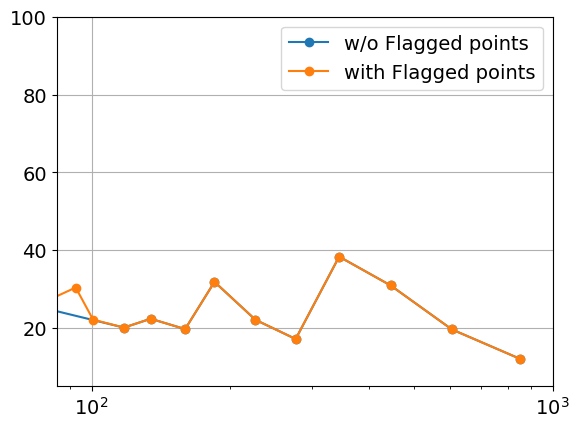

In [30]:
df_blue_on_pix = df_blue.drop(df_blue[df_blue['optimization_flag_on_pix'] == False].index)

fig, axes = plt.subplots()
axes.plot(-df_blue_on_pix["R_arcsec"]*140., df_blue_on_pix["T_exe_on_pix"], marker='o', label = 'w/o Flagged points')
axes.plot(-df_blue["R_arcsec"]*140., df_blue["T_exe_on_pix"], marker='o', label = 'with Flagged points')

formatter = LogFormatter(labelOnlyBase=False, minor_thresholds=(np.inf, np.inf))
axes.get_xaxis().set_minor_formatter(formatter)
axes.set_xlim(84, 1000)
axes.set_ylim(5,100)
axes.set_xscale('log')
axes.grid(True)
axes.legend()

plt.show()